In [ ]:
!unzip /content/semantic_segmentation_dataset.zip

Archive:  /content/semantic_segmentation_dataset.zip
replace Semantic segmentation dataset/Tile 1/images/image_part_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import json
from matplotlib.colors import to_rgb

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
import segmentation_models as sm
import random

dict = {'classes' : ['Building','Land (unpaved area)','Road','Vegetation', 'Water','Unlabeled'],
        'colors' : ['#3C1098', '#8429F6', '#6EC1E4', '#FEDD3A', '#E2A929', '#9B9B9B']}

patch_size = 224

def labelize(label):
    m,n,b = label.shape
    ref = np.zeros((m,n))
    for i,col in enumerate(dict['colors']):
        color = np.array([255 * x for x in to_rgb(col)]).astype('uint8')
        ref[np.all(label == color,axis=-1)] = i
    return ref

def patchify(img):
    m,n,b = img.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(img[i:i+patch_size,j:j+patch_size,:])
    return crops

def patchify_lab(label):
    m,n = label.shape
    crops = []
    for i in range(0,m-patch_size,patch_size):
        for j in range(0,n-patch_size,patch_size):
            crops.append(label[i:i+patch_size,j:j+patch_size])
    return crops


def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

folder = r"/content/Semantic segmentation dataset"
tiles = os.listdir(folder)
train_set = []
train_lab = []
test_set = []
test_lab = []
for tile in tiles:
    if os.path.isdir(os.path.join(folder,tile)):
        files = os.listdir(os.path.join(folder,tile,'images'))
        for file in files:
            img = imageio.imread(os.path.join(folder,tile,'images',file))/255
            img = patchify(img)
            label = imageio.imread(os.path.join(folder,tile,'masks',file[:-3] + 'png'))
            label = labelize(label)
            label = patchify_lab(label)

            if file == 'image_part_009.jpg':
                test_set = test_set + img
                test_lab = test_lab + label
            else:
                train_set = train_set + img
                train_lab = train_lab + label
                
train_set = np.array(train_set)  
test_set = np.array(test_set)  
train_lab = np.array(train_lab) 
n_classes = len(np.unique(train_lab)) 
train_lab = to_categorical(train_lab, num_classes=n_classes)
test_lab = np.array(test_lab)  
test_lab = to_categorical(test_lab, num_classes=n_classes)
print(train_set.shape)
print(test_set.shape)
print(train_lab.shape)
print(test_lab.shape)

Segmentation Models: using `keras` framework.


<ipython-input-4-fb4ca153eac3>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ref[np.all(label == color,axis=-1)] = i


(1464, 224, 224, 3)
(183, 224, 224, 3)
(1464, 224, 224, 6)
(183, 224, 224, 6)


In [ ]:
import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

def FCN8(IMG_input, nClasses,  input_height=patch_size, input_width=patch_size): 
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(IMG_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x) #1/2 of original size
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x) #1/4 of original size
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    #add one more convolutional layer
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x) #1/8 of original size
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    #add one more convolutional layer
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x) #1/16 of original size

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    #add one more convolutional layer
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x) #1/32 of original size
     
    vgg  = Model(img_input, pool5)
    # loading VGG-19 weights for the encoder parts of FCN8
    vgg.load_weights("/content/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5") 
    
    o = (Conv2D(n_classes, (7, 7), activation='relu', padding='same', name="conv6"))(pool5)
        
    ## 4 times upsamping for final layer
    conv6_4 = Conv2DTranspose(n_classes, kernel_size=(4,4),  strides=(4,4), use_bias = False)(o)
    ## 2 times upsampling for pool4
    pool4_n = ( Conv2D(n_classes, (1, 1), activation='relu', padding='same', name="pool4_n"))(pool4)
    pool4_n_2 = (Conv2DTranspose(nClasses, kernel_size=(2,2), strides=(2,2), use_bias=False))(pool4_n)
    #1 time for pool3
    pool3_n = (Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_n"))(pool3)

    o = pool4_n_2 + pool3_n + conv6_4 #combine 3 upsamplings together
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, activation='softmax')(o)
    
    
    model = Model(img_input, o)
    return model

img_input = Input(shape=(patch_size,patch_size, 3)) 
model = FCN8(img_input,n_classes,  
             input_height = 224, 
             input_width = 224)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_set, train_lab, test_size = 0.20, random_state = 42)

In [ ]:
#code for training
from tensorflow import keras

opt = keras.optimizers.SGD(learning_rate=0.033)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy', jaccard_coef])
batch_size = 8
epochs = 30
show = X_train.shape[0]//batch_size
history = model.fit(X_train,y_train,
                  validation_data=(X_val,y_val),
                  epochs=epochs,verbose=2,batch_size = batch_size
                  )

Epoch 1/30
147/147 - 11s - loss: 1.7606 - accuracy: 0.2366 - jaccard_coef: 0.0993 - val_loss: 1.7963 - val_accuracy: 0.3300 - val_jaccard_coef: 0.1611 - 11s/epoch - 72ms/step
Epoch 2/30
147/147 - 4s - loss: 1.3880 - accuracy: 0.4754 - jaccard_coef: 0.2297 - val_loss: 1.5026 - val_accuracy: 0.4648 - val_jaccard_coef: 0.1386 - 4s/epoch - 30ms/step
Epoch 3/30
147/147 - 4s - loss: 1.1152 - accuracy: 0.5283 - jaccard_coef: 0.3211 - val_loss: 1.2863 - val_accuracy: 0.5109 - val_jaccard_coef: 0.2095 - 4s/epoch - 30ms/step
Epoch 4/30
147/147 - 4s - loss: 1.0084 - accuracy: 0.6123 - jaccard_coef: 0.3579 - val_loss: 1.0850 - val_accuracy: 0.6016 - val_jaccard_coef: 0.3444 - 4s/epoch - 30ms/step
Epoch 5/30
147/147 - 4s - loss: 0.9080 - accuracy: 0.6716 - jaccard_coef: 0.3974 - val_loss: 0.9992 - val_accuracy: 0.6542 - val_jaccard_coef: 0.4223 - 4s/epoch - 30ms/step
Epoch 6/30
147/147 - 4s - loss: 0.8259 - accuracy: 0.7026 - jaccard_coef: 0.4370 - val_loss: 0.9252 - val_accuracy: 0.6943 - val_jacc

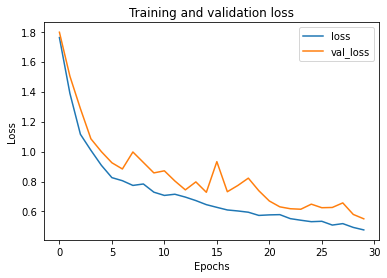

In [ ]:
#print out the chart of training loss and validation loss
for key in ['loss', 'val_loss']:
    plt.plot(history.history[key],label=key)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

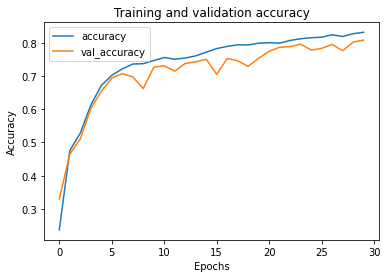

In [ ]:
#print out the chart of training accuracy and validation accuracy
for key in ['accuracy', 'val_accuracy']:
    plt.plot(history.history[key],label=key)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

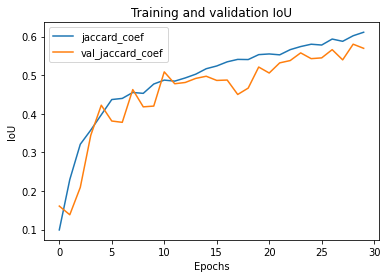

In [ ]:
#print out the chart of training IoU and validation IoU
for key in ['jaccard_coef', 'val_jaccard_coef']:
    plt.plot(history.history[key],label=key)
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
#code for testing
y_pred=model.predict(test_set)
Jacc = jaccard_coef(test_lab,y_pred)
print('IoU = {}'.format(Jacc))
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_lab, axis=3)

6/6 [==============================] - 1s 124ms/step
IoU = 0.6710201501846313


1/1 [==============================] - 0s 211ms/step


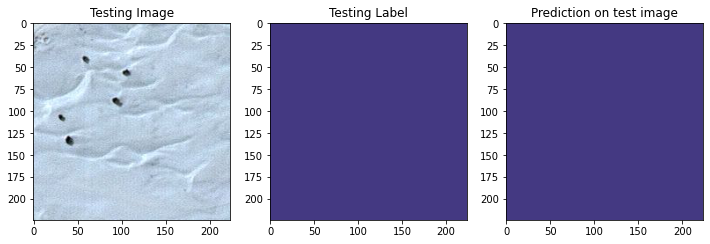

1/1 [==============================] - 0s 21ms/step


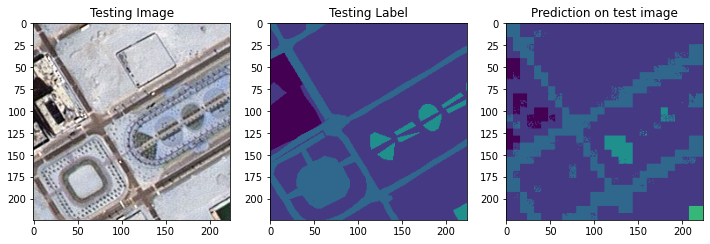

1/1 [==============================] - 0s 21ms/step


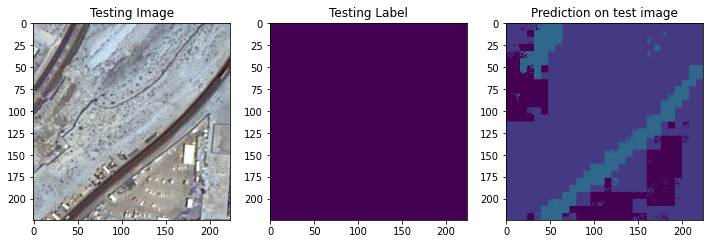

1/1 [==============================] - 0s 20ms/step


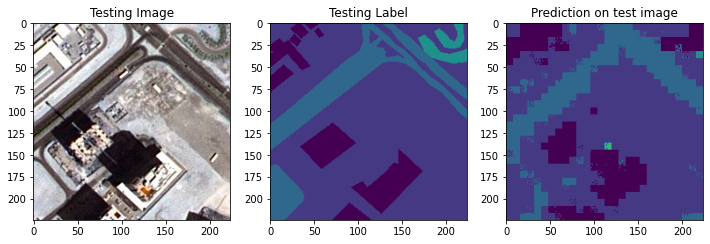

1/1 [==============================] - 0s 21ms/step


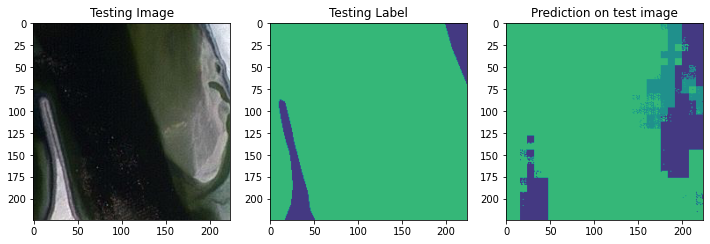

1/1 [==============================] - 0s 20ms/step


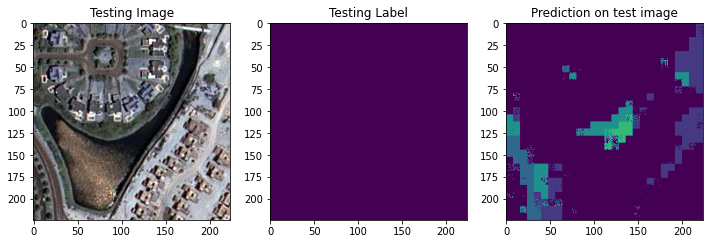

1/1 [==============================] - 0s 21ms/step


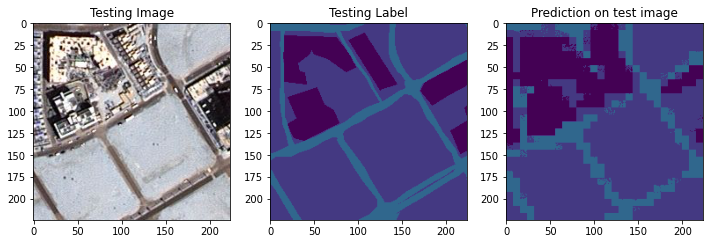

1/1 [==============================] - 0s 20ms/step


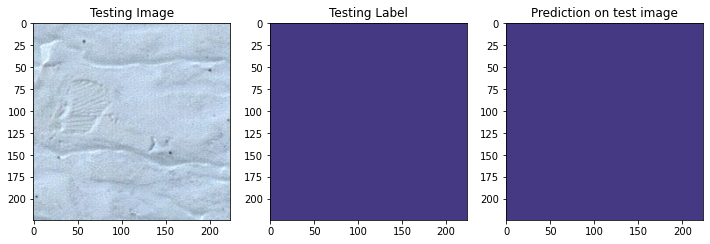

1/1 [==============================] - 0s 19ms/step


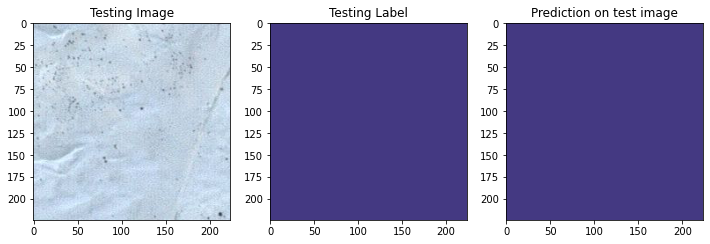

1/1 [==============================] - 0s 19ms/step


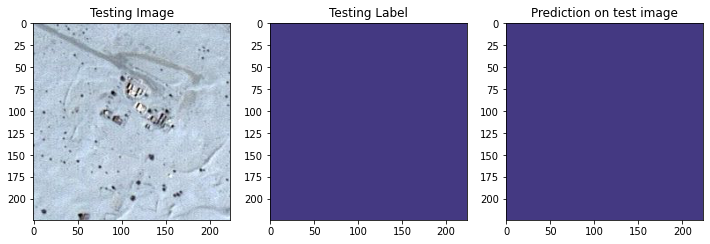

In [ ]:
#samples of result of segmantation
num_samples = 10
test_img_numbers = random.sample(range(test_set.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = test_set[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()